In [1]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


Exploring some different calibration strategies

## First show isotonic regression of emperical CDF is exactly the emperical CDF

In [2]:
from scipy.stats import norm
from sklearn import isotonic

In [3]:
x = np.random.normal(0,1,100)
x = np.sort(x)
y = np.linspace(0,1,x.size)

In [4]:
iso = isotonic.isotonic_regression(y)

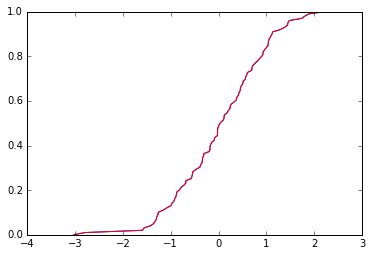

In [5]:
plt.plot(x, y)
plt.plot(x, iso, c='r')

## now try to do isotonic regression to calibrate classifier

My understanding of how this works is that we imagine samples from $p(x|y=0)$ and $p(x|y=1)$ and then using Bayes theorem (balanced samples so that $p(y=0)=p(y=1)=1/2)$ we have 

\begin{equation}
p(y=1 | x) = \frac{p(x|y=1)}{p(x|y=0)+p(x|y=1)}
\end{equation}

That's our goal, but we can't evaluate $p(x|y)$ with discrete samples. That's what isotonic regression is trying to do assuming that $p(y|x)$ is isotonic.

For this we will use $p(x|y=0) = Norm(0,1)$ and $p(x|y=1)=Norm(3,1)$

In [6]:
from sklearn.isotonic import IsotonicRegression
iso_regressor = IsotonicRegression(out_of_bounds='clip') 

In [7]:
#scikit-learn says it uses interp1d for predict, but that doesn't seem to be true
from scipy.interpolate import interp1d

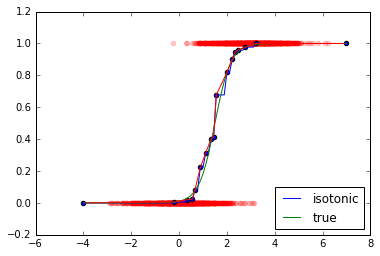

In [8]:
mean_1 = 3
x0 = np.random.normal(0,1,1000)
x0 = np.sort(x0)
x1 = np.random.normal(mean_1,1,1000)
x1 = np.sort(x1)
target = np.zeros(x0.size+x1.size)
target[x0.size:]=1.

iso_regressor.fit(np.hstack((x0,x1)), target)

test = np.linspace(-4,7,100)
plt.scatter(np.hstack((x0,x1)), target, alpha=0.2, color='r')
p = iso_regressor.predict(test)
plt.plot(test,p, label='isotonic')
plt.plot(test, norm.pdf(test,loc=mean_1)/(norm.pdf(test,loc=mean_1)+norm.pdf(test,loc=0)), label='true')

change_mask = (p-np.roll(p,1))>0
change_mask[0] = True
change_mask[-1] = True
plt.scatter(test[change_mask],p[change_mask])

iso_interp = interp1d(test[change_mask],p[change_mask])

plt.plot(test[1:-1], iso_interp(test[1:-1]))
plt.legend(loc='lower right')

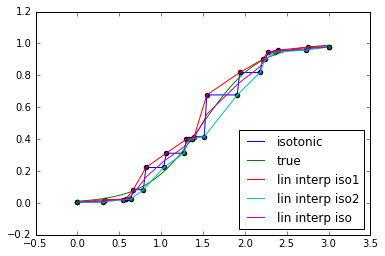

In [9]:
test = np.linspace(0,3,100)

p = iso_regressor.predict(test)
plt.plot(test,p, label='isotonic')

plt.plot(test, norm.pdf(test,loc=mean_1)/(norm.pdf(test,loc=mean_1)+norm.pdf(test,loc=0)), label='true')

change_mask1 = (p-np.roll(p,1))>0
change_mask2 = np.roll(change_mask1,-1)
change_mask1[0] = True
change_mask1[-1] = True
change_mask2[0] = True
change_mask2[-1] = True

plt.scatter(test[change_mask1],p[change_mask1], c='b')
plt.scatter(test[change_mask2],p[change_mask2],c='g')

iso_interp1 = interp1d(test[change_mask1],p[change_mask1])
iso_interp2 = interp1d(test[change_mask2],p[change_mask2])
iso_interp = lambda x: .5*(iso_interp1(x)+iso_interp2(x))

plt.plot(test[1:-1], iso_interp1(test[1:-1]),label='lin interp iso1')
plt.plot(test[1:-1], iso_interp2(test[1:-1]),label='lin interp iso2')

plt.plot(test[1:-1], iso_interp(test[1:-1]),label='lin interp iso')

plt.legend(loc='lower right')

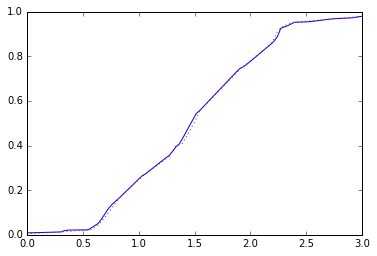

In [10]:
from carl.learning import InterpolatedIsotonicRegression
interp_iso_regressor = InterpolatedIsotonicRegression(out_of_bounds='clip') 
interp_iso_regressor.fit(np.hstack((x0,x1)), target)
p_iir = interp_iso_regressor.predict(test)

plt.plot(test,p_iir, label='interp isotonic')
plt.plot(test[1:-1],iso_interp(test[1:-1]), label='interp isotonic', c='r',ls='dotted')

Notice the isotonic is not doing so well in the important part of the turn on.

## Try a GP

Let's try the same thing with a GP to smooth out the discontinuities. However, this won't be constrained to be isotonic. Also, it will be slow when there are many samples

(-0.1, 1.1)

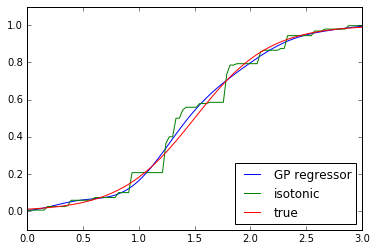

In [497]:
from sklearn.gaussian_process import GaussianProcessRegressor
gp = GaussianProcessRegressor(optimizer=None)
gp.fit(np.hstack((x0,x1)).reshape(-1,1), target)

#plt.scatter(np.hstack((x0,x1)), target, alpha=0.2, color='r')
p_gp = gp.predict(test.reshape(-1,1))
plt.plot(test,p_gp, label='GP regressor')
plt.plot(test,p, label='isotonic')
plt.plot(test, norm.pdf(test,loc=mean_1)/(norm.pdf(test,loc=mean_1)+norm.pdf(test,loc=0)), label='true')
plt.legend(loc='lower right')
plt.ylim(-.1,1.1)


Much better, but it has issues far away

(-0.1, 1.1)

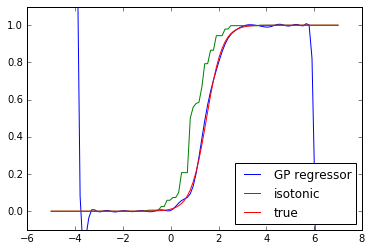

In [494]:
test = np.linspace(-5,7,100)
p_gp = gp.predict(test.reshape(-1,1))
plt.plot(test,p_gp, label='GP regressor')
plt.plot(test,p, label='isotonic')
plt.plot(test, norm.pdf(test,loc=mean_1)/(norm.pdf(test,loc=mean_1)+norm.pdf(test,loc=0)), label='true')
plt.legend(loc='lower right')
plt.ylim(-.1,1.1)

## To do: try to fix up the GP to make it monotonic  

In [435]:
# this algorithm isn't going to work, only catches when derivative is <0
def force_monotonic(array, it=0):
    if it>10:
        return array
    first = np.argmax((array-np.roll(array,1))[1:]<0)
    last = np.argmax((array-np.roll(array,1))[1:]>=0)

    print(first, last)
    if first==0 and last==0:
        return array
    else:
        array[first:last]=array[last+1]
        return force_monotonic(array, it=it+1)

In [436]:
p_gp_new = force_monotonic(p_gp.copy())

0 11
10 0
10 0
10 0
10 0
10 0
10 0
10 0
10 0
10 0
10 0


(-0.1, 1.1)

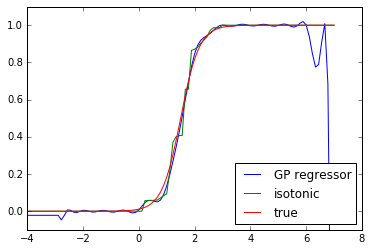

In [437]:
plt.plot(test,p_gp_new, label='GP regressor')
plt.plot(test,p, label='isotonic')
plt.plot(test, norm.pdf(test,loc=mean_1)/(norm.pdf(test,loc=mean_1)+norm.pdf(test,loc=0)), label='true')
plt.legend(loc='lower right')
plt.ylim(-.1,1.1)

## Hybrid isotonic+GP
Use isotonic for y~0 and y~1 and GP for other parts

13 85 [ 0.09335709  0.91448092] 0.907204627991


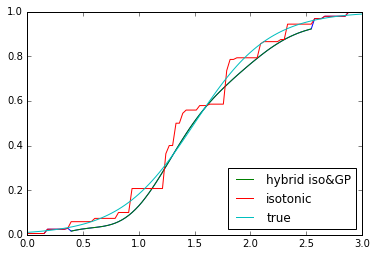

In [556]:
low_mask = p<0.05
high_mask = p>0.95
low_index = np.argmin(low_mask)
high_index = np.argmax(high_mask)
gp_low = p_gp[low_index]
gp_high = p_gp[high_index]
p_low = p[low_index]
p_high = p[high_index]
gp_range = gp_high-gp_low
p_range = p_high-p_low
print(low_index, high_index, gp_low_high, gp_range)
hybrid = np.zeros(test.size)
hybrid[low_mask]=p[low_mask]
hybrid[high_mask]=p[high_mask]
gp_mask = np.logical_not(low_mask + high_mask)
hybrid[gp_mask]=(p_gp[gp_mask]-gp_low_high[0])*p_range/gp_range+p[low_index]
plt.plot(test,hybrid)
plt.plot(test[gp_mask],hybrid[gp_mask], label='hybrid iso&GP')
plt.plot(test,p, label='isotonic')
plt.plot(test, norm.pdf(test,loc=mean_1)/(norm.pdf(test,loc=mean_1)+norm.pdf(test,loc=0)), label='true')
plt.legend(loc='lower right')

In [543]:
np.logical_not(low_mask + high_mask)

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False, False], dtype=bool)

## Try using histograms with equal-probability bins 

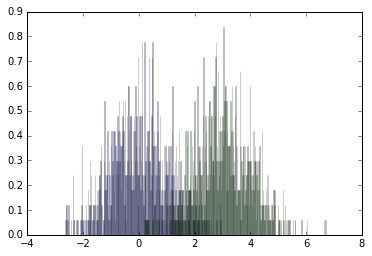

In [441]:
h0 = plt.hist((x0), bins=np.linspace(-3,7,600), normed=True, alpha=0.2)
h1 = plt.hist((x1), bins=np.linspace(-3,7,600), normed=True, alpha=0.2)

In [457]:
widths = (h0[1]-np.roll(h0[1],1))[1:]
cdf0 = np.cumsum(h0[0]*widths)
newbins0 = h0[1][np.searchsorted(cdf0, np.linspace(0,1,10))]
newbins0

widths = (h1[1]-np.roll(h1[1],1))[1:]
cdf1 = np.cumsum(h1[0]*widths)
newbins1 = h1[1][np.searchsorted(cdf1, np.linspace(0,1,10))]
newbins1

array([-3.        ,  1.82470785,  2.20868114,  2.55926544,  2.8096828 ,
        3.07679466,  3.39398998,  3.77796327,  4.21202003,  6.68280467])

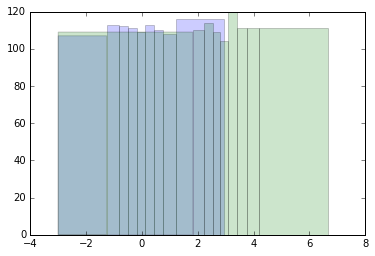

In [458]:
hnew0 = plt.hist(x0, bins=newbins0, normed=False, alpha=0.2)
hnew1 = plt.hist(x1, bins=newbins1, normed=False, alpha=0.2)

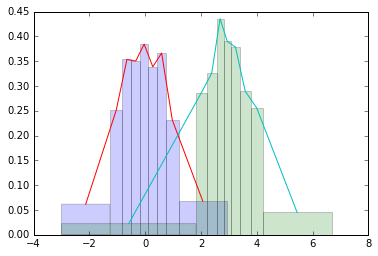

In [466]:
hnew0 = plt.hist(x0, bins=newbins0, normed=True, alpha=0.2)
hnew1 = plt.hist(x1, bins=newbins1, normed=True, alpha=0.2)
plt.plot(.5*(hnew0[1][1:]+hnew0[1][:-1]), hnew0[0])
plt.plot(.5*(hnew1[1][1:]+hnew1[1][:-1]), hnew1[0])

In [472]:
def p0_posterior(x):
    #p0_interp = interp1d(.5*(hnew0[1][1:]+hnew0[1][:-1]), hnew0[0])
    #p1_interp = interp1d(.5*(hnew1[1][1:]+hnew1[1][:-1]), hnew1[0])
    #return p1_interp(x)/(p0_interp(x)+p1_interp(x))
    
    index0 = np.argmax(hnew0[1]>x)-1
    index1 = np.argmax(hnew1[1]>x)-1
    return hnew1[0][index1]/(hnew0[0][index0]+hnew1[0][index1])


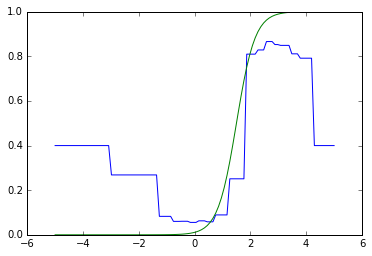

In [474]:
test = np.linspace(-5,5,100)
p0test = np.zeros(100)
for i, xx in enumerate(test):
    p0test[i] = p0_posterior(xx)

plt.plot(test,p0test)
plt.plot(test, norm.pdf(test,loc=mean_1)/(norm.pdf(test,loc=mean_1)+norm.pdf(test,loc=0)))


    

In [475]:
hnew0[0]

array([ 0.06168957,  0.25094354,  0.35344819,  0.3502924 ,  0.38444916,
        0.33877377,  0.36642198,  0.23127413,  0.06752772])